In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
from dataclasses import dataclass
from datetime import datetime as dt
import json
import os
from pathlib import Path
from pprint import pprint
import sys
if '..' not in sys.path:
    sys.path.append('..')
import shutil
import traceback
from typing import Union, Any, Optional
import yaml

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import torch

from segm.optim.factory import create_optimizer, create_scheduler

from sdp.ds.bop_data import read_models_info, read_scene_camera, read_scene_gt, \
    read_scene_gt_info
from sdp.ds.bop_dataset import BopDataset, BopEpochIterator, AUGNAME_DEFAULT
from sdp.ds.emb_dataset import EmbDataset
from sdp.models.segmenter.factory import create_vit, create_segmenter
from sdp.utils.tensor import stack_imgs_maps
from sdp.utils.train import ArgsAaeBase, ConfigAaeTrain




/tmp/ipykernel_4354/1005785164.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
DATA_PATH = Path(os.path.expandvars('$HOME/data'))
BOP_PATH = DATA_PATH / 'bop'
ITODD_SUBDIR = 'itodd'
ITODD_BOP_PATH = BOP_PATH / ITODD_SUBDIR
print(f'BOP path: {BOP_PATH}')
TRAIN_ROOT_PATH = DATA_PATH / 'train_aae'

BOP path: /home/misha/data/bop


In [6]:
ds = BopDataset.from_dir(BOP_PATH, ITODD_SUBDIR, shuffle=False)


Reading dataset from /home/misha/data/bop/itodd/.sdp/v0.0.1


In [7]:
# train_subdir = 'ds_itodd_obj_1_imsz_256_20231024_214603'
# train_subdir = 'ds_itodd_obj_1_imsz_256_20240112_232615'
train_subdir = 'ds_itodd_obj_1_imsz_256_20240123_230629'
print(ds.get_cache_path())
emb_ds = EmbDataset.read_cache(ds.get_cache_path() / train_subdir)

/home/misha/data/bop/itodd/.sdp/v0.0.1
EmbDataset reading cache from /home/misha/data/bop/itodd/.sdp/v0.0.1/ds_itodd_obj_1_imsz_256_20240123_230629


In [8]:
emb_ds.obj_ds_ids.shape, emb_ds.obj_ds_ids.dtype, emb_ds.embs.shape, emb_ds.embs.dtype

((16071,), dtype('int64'), (16071, 1000), dtype('float32'))

In [9]:
from scipy.spatial import KDTree
obj_ds_ids, embs, tcfg = emb_ds.obj_ds_ids, emb_ds.embs, emb_ds.tcfg
objs_view = ds.get_objs_view(tcfg.obj_id, keep_source_images=True, keep_cropped_images=True, return_tensors=False)
objs_view.set_out_size(tcfg.img_size)

min_mask_ratio: 20671 --> 18066
min_bbox_dim_ratio: 18066 --> 16071


In [10]:
embs.shape, embs.dtype

((16071, 1000), dtype('float32'))

In [11]:
y = embs
print(y.shape, np.linalg.norm(y[0] - y[1]), np.linalg.norm(y[0] - y[2]))


(16071, 1000) 68.42826 56.555565


In [12]:
kdt = KDTree(embs)

In [13]:
i1 = 23
x = embs[i1]
dists, inds = kdt.query(x, 2)
print(dists, inds)
i2 = inds[1]
print(np.linalg.norm(x - embs[i2]))
print(np.linalg.norm(embs[100:200] - x, axis=1))



[ 0.         47.28646963] [  23 3096]
47.28647
[73.77378  79.80696  68.30053  83.16994  70.43158  80.64     78.15099
 77.32304  73.74637  81.055145 70.947655 75.75952  79.37726  75.69452
 79.95639  78.81861  74.12248  78.19732  67.16856  78.33525  77.94731
 75.09241  79.32139  78.98038  70.26929  80.31853  68.822205 77.21112
 73.48536  77.416374 70.49957  80.64486  68.00699  74.963554 70.26291
 73.32003  75.004524 89.34667  87.534424 74.48582  79.6238   77.82322
 77.03736  66.179665 78.74904  65.56976  72.835045 70.58637  78.60253
 73.36592  71.485535 74.76235  74.741875 73.866264 79.49122  69.996025
 70.01107  69.959305 67.418304 79.73029  82.5589   73.56115  68.25654
 74.84309  70.04622  65.20204  79.26826  79.102425 79.87456  71.595146
 75.80124  73.191696 73.17409  72.747086 69.802925 73.90067  81.02699
 66.731804 80.1015   76.15943  74.78628  70.34287  78.14216  78.811745
 69.87903  80.41377  67.768616 75.3937   71.563965 76.79459  71.030655
 73.01661  77.41233  75.84678  74.25886

In [14]:
x = embs[i1]
dx = np.linalg.norm(x)
i2, d2 = None, np.inf
i3, d3 = None, np.inf
obj_ds_id1 = obj_ds_ids[i1]
R1, t1 = ds.df_obj.loc[obj_ds_id1]['R_m2c'], ds.df_obj.loc[obj_ds_id1]['t_m2c']
RR1 = R.from_matrix(R1)
for i, y in enumerate(embs):
    if i == i1: continue
    dy = np.linalg.norm(y)
    # d = 1 - np.sum(x * y) / dx / dy
    d = np.linalg.norm(x - y)
    if d < d2:
        d2 = d
        i2 = i
        print('emb:', i, d)
    
    obj_ds_id2 = obj_ds_ids[i]
    R2, t2 = ds.df_obj.loc[obj_ds_id2]['R_m2c'], ds.df_obj.loc[obj_ds_id2]['t_m2c']
    RR2 = R.from_matrix(R2)
    rv1, rv2 = RR1.as_rotvec(), RR2.as_rotvec()
    # ang1, ang2 = np.linalg.norm(rv1), np.linalg.norm(rv2)
    # dd = np.sqrt((ang1 - ang2)**2 + np.linalg.norm(rv1 / ang1 - rv2 / ang2)**2)
    dd = np.linalg.norm(rv1 - rv2)
    if dd < d3:
        d3 = dd
        i3 = i
        print('gt:', i, dd)




emb: 0 72.493
gt: 0 4.1437857527715405
gt: 1 4.114459023200408
emb: 2 70.198006
gt: 2 2.963190993550238
gt: 5 2.1382274781649895
emb: 6 69.53288
gt: 7 1.8652306826878693
gt: 11 1.1607966818910056
emb: 12 69.16289
gt: 13 0.8347195824779389
emb: 19 63.826492
gt: 43 0.2699516277596092
emb: 196 61.49871
emb: 333 59.96771
gt: 466 0.25881991442768787
gt: 531 0.2297431415710979
emb: 661 59.849026
emb: 985 58.526104
emb: 2259 57.913845
emb: 2467 55.12478
emb: 3096 47.28647
gt: 5878 0.16412936540511533


In [15]:
obj_ds_id1, obj_ds_id2, obj_ds_id3 = obj_ds_ids[i1], obj_ds_ids[i2], obj_ds_ids[i3]

In [16]:
gt = objs_view.get_gt_imgs_masks([obj_ds_id1, obj_ds_id2, obj_ds_id3], is_ids=True)

3


(<matplotlib.image.AxesImage at 0x7fed135101c0>,
 <matplotlib.image.AxesImage at 0x7fed1354e590>)

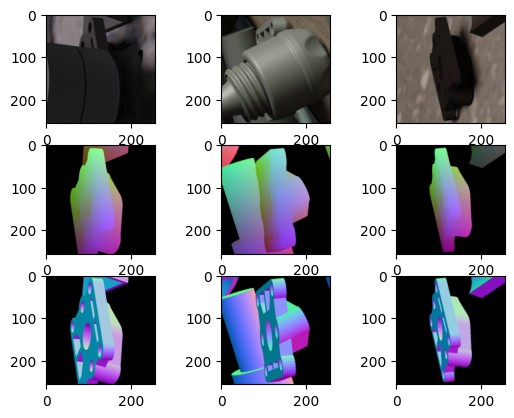

In [17]:
fig, axes = plt.subplots(3, 3)
print(len(gt.imgs_crop))
axes[0, 0].imshow(gt.imgs_crop[0]), axes[0, 1].imshow(gt.imgs_crop[1]), axes[0, 2].imshow(gt.imgs_crop[2])
axes[1, 0].imshow(gt.maps_crop['noc'][0]), axes[1, 1].imshow(gt.maps_crop['noc'][1]), axes[1, 2].imshow(gt.maps_crop['noc'][2])
axes[2, 0].imshow(gt.maps_crop['norm'][0]), axes[2, 1].imshow(gt.maps_crop['norm'][1]), axes[2, 2].imshow(gt.maps_crop['norm'][2])


In [18]:
inp_ch, n_cls = 9, 6
backbone = 'vit_tiny_patch16_384'
model_cfg = {
    'n_cls': n_cls,
    'backbone': backbone,
    'image_size': (tcfg.img_size, tcfg.img_size),
    'channels': inp_ch,
    'patch_size': 16,
    'd_model': 192,
    'n_heads': 3,
    'n_layers': 12,
    'normalization': 'vit',
    'distilled': False,
}
encoder = create_vit(model_cfg)
device = torch.device('cpu')
# device = torch.device('cuda')
encoder.to(device)
model_cfg = {
    **model_cfg,
    'decoder': {
        'name': 'mask_transformer',
        'drop_path_rate': 0.1,
        'dropout': 0.1,
        'n_layers': 2
    }
}
model = create_segmenter(model_cfg)
model.to(device)# print(encoder)
print(f'Loading model from {tcfg.best_checkpoint_fpath}')
checkpoint = torch.load(tcfg.best_checkpoint_fpath)
print(f'Checkpoint keys: {list(checkpoint.keys())}')
encoder.load_state_dict(checkpoint['model'], strict=False)
model.load_state_dict(checkpoint['model'])
encoder.eval()
model.eval()


default_cfg: {'url': 'https://storage.googleapis.com/vit_models/augreg/Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz', 'num_classes': 1000, 'input_size': (3, 384, 384), 'pool_size': None, 'crop_pct': 1.0, 'interpolation': 'bicubic', 'fixed_input_size': True, 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'first_conv': 'patch_embed.proj', 'classifier': 'head', 'hf_hub_id': None}
load_custom_pretrained
{'n_cls': 6, 'backbone': 'vit_tiny_patch16_384', 'image_size': (256, 256), 'channels': 9, 'patch_size': 16, 'd_model': 192, 'n_heads': 3, 'n_layers': 12, 'normalization': 'vit', 'distilled': False}
default_cfg: {'url': 'https://storage.googleapis.com/vit_models/augreg/Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz', 'num_classes': 1000, 'input_size': (3, 256, 256), 'pool_size': None, 'crop_pct': 1.0, 'interpolation': 'bicubic', 'fixed_input_size': True, 'mean': (0.5, 0.5, 0.5), 's

Segmenter(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(9, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.1, inplace=False)
        )
        (mlp): FeedForward(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (drop_path): Identity()
      )
    )
    (norm):

In [19]:
gt.to_tensors()
x = stack_imgs_maps(gt.maps_crop_tn, gt.maps_names, gt.imgs_crop_tn)
x = x.to(device)
yy = model.forward(x)
yy = (yy + 1) / 2
yy = yy.detach().to('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x7fed0ad85ed0>,
 <matplotlib.image.AxesImage at 0x7fed0ad86530>)

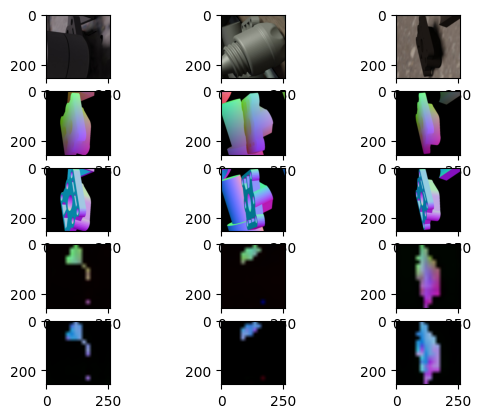

In [20]:
fig, axes = plt.subplots(5, 3)
y = np.asarray(yy.permute(0, 2, 3, 1))
axes[0, 0].imshow(gt.imgs_crop[0]), axes[0, 1].imshow(gt.imgs_crop[1]), axes[0, 2].imshow(gt.imgs_crop[2])
axes[1, 0].imshow(gt.maps_crop['noc'][0]), axes[1, 1].imshow(gt.maps_crop['noc'][1]), axes[1, 2].imshow(gt.maps_crop['noc'][2])
axes[2, 0].imshow(gt.maps_crop['norm'][0]), axes[2, 1].imshow(gt.maps_crop['norm'][1]), axes[2, 2].imshow(gt.maps_crop['norm'][2])
axes[3, 0].imshow(y[0][..., 3:]), axes[3, 1].imshow(y[1][..., 3:]), axes[3, 2].imshow(y[2][..., 3:])
axes[4, 0].imshow(y[0][..., :3]), axes[4, 1].imshow(y[1][..., :3]), axes[4, 2].imshow(y[2][..., :3])


In [21]:
ye = encoder.forward(x)
ye = ye.detach().to('cpu')
ye.shape, ye.dtype

(torch.Size([3, 1000]), torch.float32)

In [22]:
yye = np.asarray(ye)
yye.shape, yye.dtype, yye.min(), yye.mean(), yye.max()

((3, 1000), dtype('float32'), -8.618632, 0.0019805755, 8.5954275)

In [23]:
print(np.linalg.norm(yye[0] - yye[1]), np.linalg.norm(yye[0] - yye[2]))

47.28643 72.666306


In [24]:
gt.df_obj.index, set(obj_ds_ids).intersection(gt.df_obj.index)

(Index([259417, 444371, 628783], dtype='int64', name='obj_ds_id'),
 {259417, 444371, 628783})

In [25]:
xx = x[:, :6, ...]
gt.masks_crop[0].shape

(256, 256)

In [40]:
mask = xx > 0
nmask = ~mask
(xx[mask] - yy[mask]).square().mean(), (xx[nmask] - yy[nmask]).square().mean()

(tensor(0.1692), tensor(0.0038))

In [44]:
z = yy[0, 0, :3, :3]
z, z.square()

(tensor([[-0.0153, -0.0153, -0.0153],
         [-0.0153, -0.0153, -0.0153],
         [-0.0153, -0.0153, -0.0153]]),
 tensor([[0.0002, 0.0002, 0.0002],
         [0.0002, 0.0002, 0.0002],
         [0.0002, 0.0002, 0.0002]]))